# Applied Machine Learning: Assignment \#08

### Sheetal Parikh
EN.605.631.81<br>
March 22, 2021
***
***

*Please refer to the Assignment 8 dataset. This dataset is composed of two features belonging to certain species. The goal is refining the data about these species such that classes of species and their features can be used to classify the data input from new observations.* 

## Problem 1
*How many species must be there in the dataset? (For the rest of this assignment, use that number as the number-of-clusters parameter in methods such as KMeans)*

In [1]:
# imports for notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.cluster import KMeans
from numpy import sqrt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import DBSCAN
import os 

#checking current directory
#print(os.getcwd() + "\n")

# change the current directory 
# to specified directory 
os.chdir(r"C:\Users\Sheetal\Documents\Sheetal") 

#Read in file
relative_path = 'datasets/assignment08_dataset.csv'
df_org = pd.read_csv(relative_path)

# Sanity check
print(f'N rows={len(df_org)}, M columns={len(df_org.columns)}')

#print first few rows to visualize dataset
df_org.head()

N rows=750, M columns=2


,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


In [2]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      750 non-null    float64
 1   f2      750 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB


In [3]:
df_org.describe()

,f1,f2
count,7.500000e+02,7.500000e+02
mean,5.218196e-15,-7.853703e-14
std,1.000667e+00,1.000667e+00
min,-2.274474e+00,-1.823801e+00
25%,-1.091894e+00,-7.775487e-01
50%,3.886712e-01,-4.095144e-01
75%,7.787849e-01,1.052538e+00
max,1.870438e+00,2.245794e+00


In [4]:
df_org.isnull().sum()

f1    0
f2    0
dtype: int64

We can see above the dataset doesn't have any null values and we have 750 entries comprising of both features.  We can now plot a scatterplot of the dataset to see if any patterns are obvious.

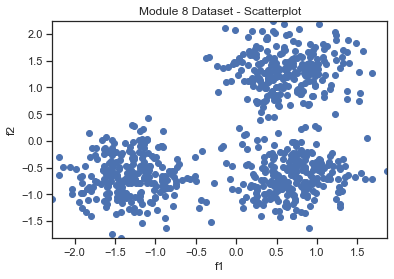

In [5]:
#splitting into x and y axis
x1 = df_org[['f1']].iloc[: , :].values
y1 = df_org[['f2']].iloc[: , :].values
 
# Visualizing the data
plt.plot()
plt.xlim([x1.min(), x1.max()])
plt.ylim([y1.min(), y1.max()])
plt.title('Module 8 Dataset - Scatterplot')
plt.xlabel("f1")
plt.ylabel("f2")
plt.scatter(x1, y1)
plt.show()

From the plot above, the dataset already appears to have 3 clusters that are pretty well defined.  We can use the elbow method to confirm.

### Elbow Method

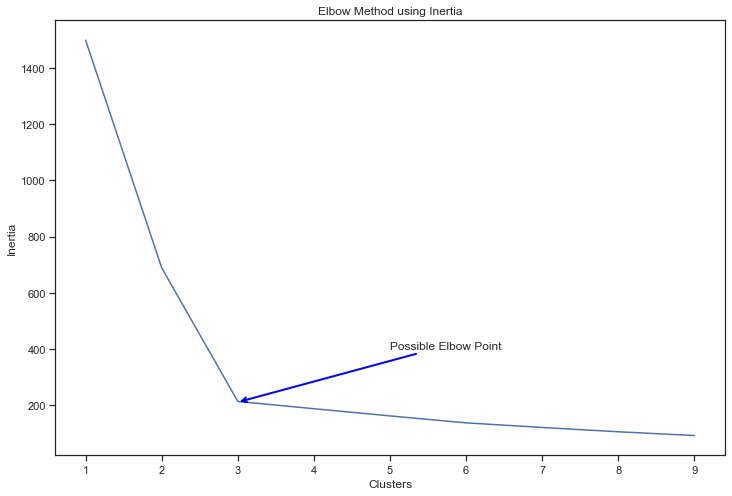

In [6]:
#using elbow method to check number of species
clusters = []

x_total = df_org.iloc[: , :].values

#checking clusters 1-10
for i in range(1, 10):
    km = KMeans(n_clusters=i).fit(x_total)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 10)), y=clusters, ax=ax)
ax.set_title('Elbow Method using Inertia')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# adding arrow pointing to possible elbow
ax.annotate('Possible Elbow Point', xy=(3, 210), xytext=(5, 400), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

Using the elbow method, it appears most likely that the dataset has 3 clusters or 3 species.

***

## Problem 2

*Find the rough feature ranges to classify these species correctly. It might be a good idea to do this step visually from some data plots.*

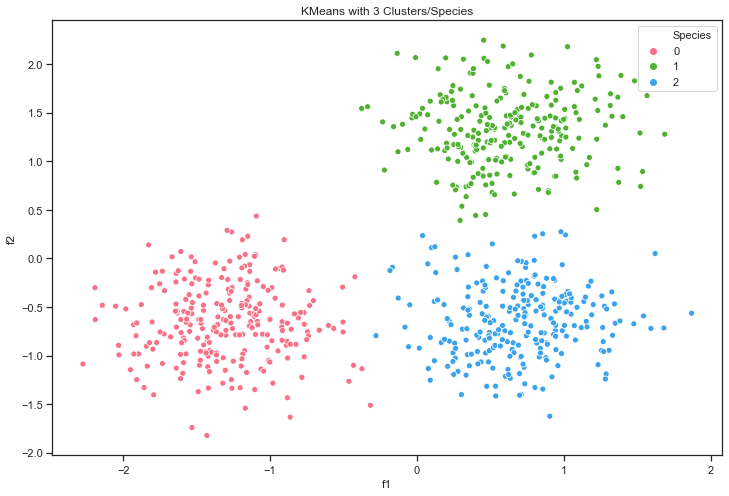

In [7]:
df = df_org.copy() 
km3 = KMeans(n_clusters=3, init='k-means++',
                n_init=1, verbose=0, max_iter=300, random_state=42)
km3.fit(df)

#creating lablels for the three species and plotting them
df['Species'] = km3.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(df['f1'], df['f2'], hue=df['Species'], 
                palette=sns.color_palette('husl', 3))
plt.title('KMeans with 3 Clusters/Species')
plt.show()

In [8]:
df.head()

,f1,f2,Species
0,0.494261,1.451067,1
1,-1.428081,-0.837064,0
2,0.338559,1.038759,1
3,0.119001,-1.053976,2
4,1.122425,1.774937,1


Using kmeans clustering we can create labels for the datapoints in each cluster as shown above.  In problem 1, we demonstrated that there are probably 3 species.  Based on the plot above we can see possible outliers but can visualize the data using a different plot to better see the ranges.

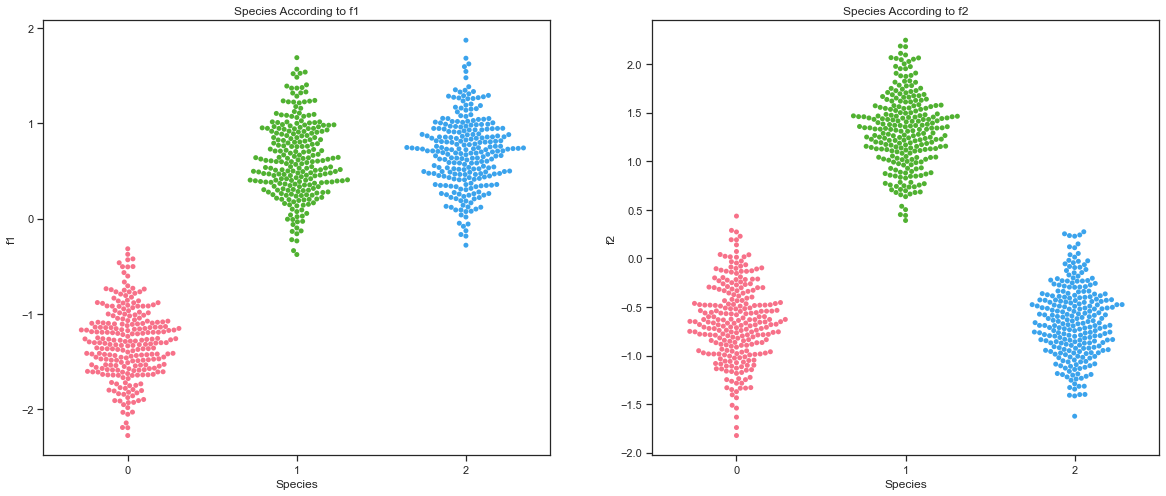

In [9]:
#swarmplot for the entire dataset

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='Species', y='f1', data=df, ax=ax, palette=sns.color_palette('husl', 3))
ax.set_title('Species According to f1')
#sns.color_palette("husl", 8)

ax = fig.add_subplot(122)
sns.swarmplot(x='Species', y='f2', data=df, ax=ax, palette=sns.color_palette('husl', 3))
ax.set_title('Species According to f2')
#sns.color_palette("husl", 8)

plt.show()

I believe this plot gives a better visualization of each species and it's range for each feature.  However, we can take a further look at each species using the same type of plot.

In [10]:
#splitting dataset into each species to use in the plots below

#boolean for where the species is 0, 1, 2
is_0 = df['Species']==0
is_1 = df['Species']==1
is_2 = df['Species']==2

#splitting each species into a separate dataframe
df_species0 = df[is_0]
df_species1 = df[is_1]
df_species2 = df[is_2]


print(f'Number of Species 0 = {len(df_species0)}')
print(f'Number of Species 1 = {len(df_species1)}')
print(f'Number of Species 2 = {len(df_species2)}')


Number of Species 0 = 252
Number of Species 1 = 248
Number of Species 2 = 250


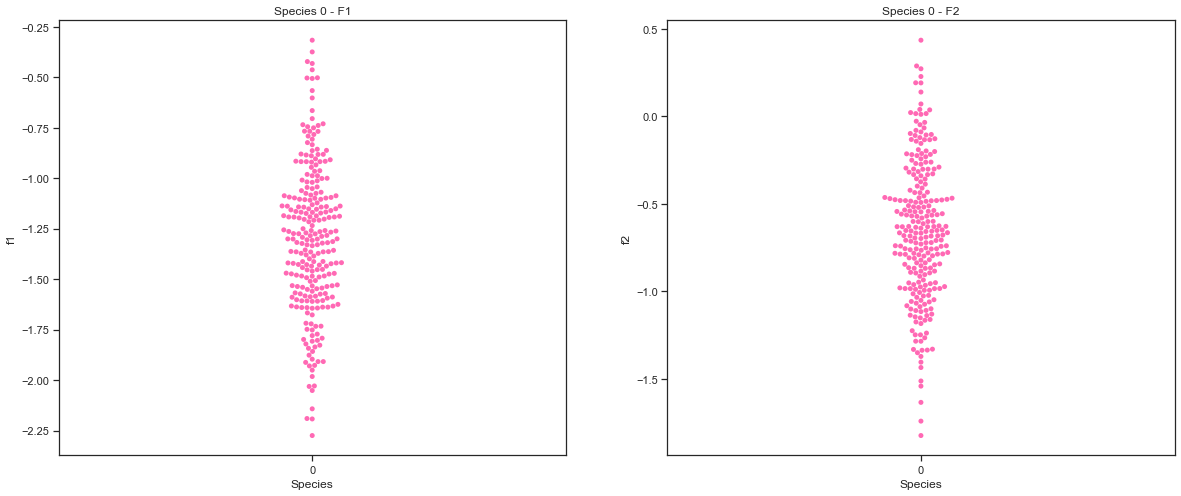

In [11]:
#swarmplot of Species 0

#plot for f1 -  color change to match joint species swarmplot
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='Species', y='f1', data=df_species0, ax=ax, color = 'hotpink')
ax.set_title('Species 0 - F1')


#plot for f2 -  color change to match joint species swarmplot
ax = fig.add_subplot(122)
sns.swarmplot(x='Species', y='f2', data=df_species0, ax=ax, color = 'hotpink')
ax.set_title('Species 0 - F2')


plt.show()

Based on the plot above, a rough range of feature f1 for species 1 would be: -2.00 to -0.625. A rough range of feature f2 for species 1 would be: -1.40 to 0.10.

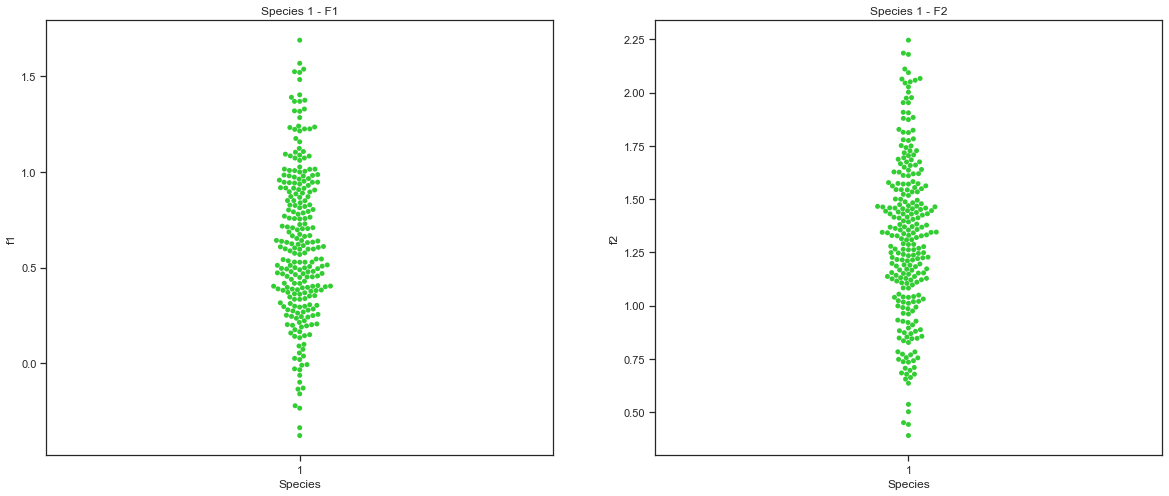

In [12]:
#swarmplot of Species 1

#plot for f1 -  color change to match joint species swarmplot
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='Species', y='f1', data=df_species1, ax=ax, color = 'limegreen')
ax.set_title('Species 1 - F1')

#plot for f2 -  color change to match joint species swarmplot
ax = fig.add_subplot(122)
sns.swarmplot(x='Species', y='f2', data=df_species1, ax=ax, color = 'limegreen')
ax.set_title('Species 1 - F2')

plt.show()

Based on the plot above, a rough range of feature f1 for species 3 would be: 0 to 1.30. A rough range of feature f2 for species 3 would be: 0.625 to 2.00

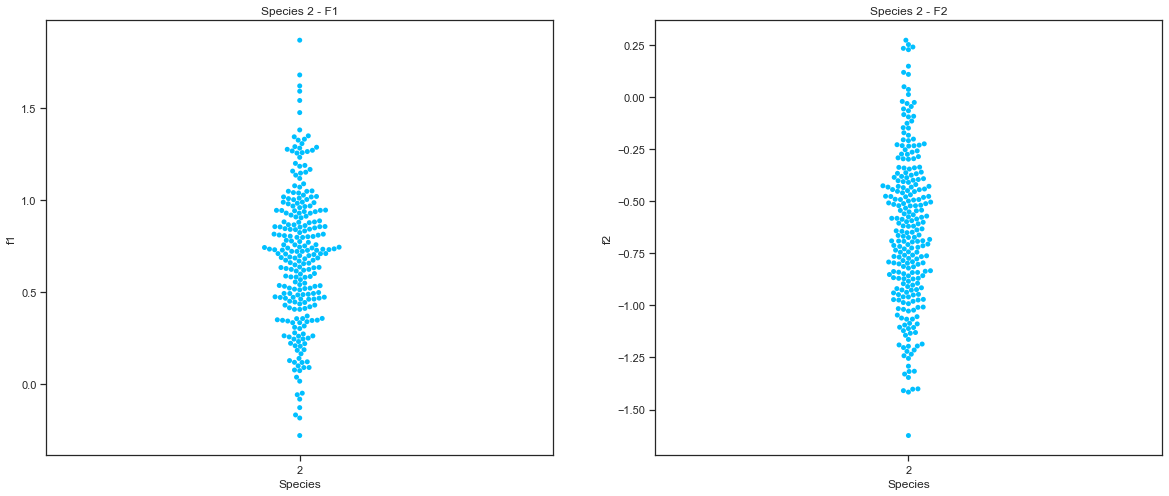

In [13]:
#swarmplot of Species 2

#plot for f1 - color change to match joint species swarmplot
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='Species', y='f1', data=df_species2, ax=ax, color = 'deepskyblue')
ax.set_title('Species 2 - F1')

#plot for f2 -  color change to match joint species swarmplot
ax = fig.add_subplot(122)
sns.swarmplot(x='Species', y='f2', data=df_species2, ax=ax, color = 'deepskyblue')
ax.set_title('Species 2 - F2')

plt.show()

Based on the plot above, a rough range of feature f1 for species 0 would be: 0 to 1.40. A rough range of feature f2 for species 0 would be: -1.25 to 0.00.

Summarizing the plots for each species, the rough ranges by just observing the graph:
    
Species 0 <br>
f1: [-2.00, -0.625]<br>
f2: [-1.40, 0.10]<br>
    
Species 1<br>
f1: [0.00,1.30] <br>
f2: [0.625, 2.00]<br>

Species 2<br>
f1: [0.00, 1.40]<br>
f2: [-1.25, 0.00]<br>

***

## Problem 3

*Clean the points that are around the boundaries of the cluster (these points might be due to errors, anomalies, or they are simply outliers). This step is done to refine feature boundaries so that a scientist can classify the species manually, reliably, and with a high level generalization. (An example statement, "Species 1 has feature 1 in the range of [0-1.5]")*

### Manually cleaning outliers using rough ranges from problem 2

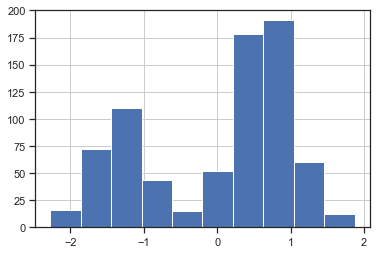

In [14]:
df.f1.hist()

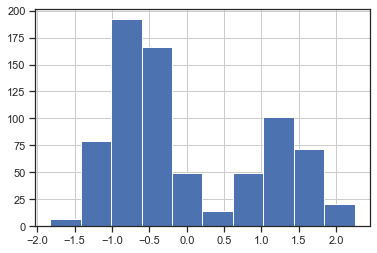

In [15]:
df.f2.hist()

Above I was visualizing the dataset as historgrams to see if there are any obvious outliers.  Based on the histograms, I believe it will easier to remove outliers separately from each species dataset rather than removing outliers from the entire dataset. 

In [16]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#defining what datapoints should be removed based on rough ranges from problem 2
index_0 = df_species0[(df_species0['f1'] > -0.625)|(df_species0['f1'] 
                                                    < -2.00)|(df_species0['f2'] > 0.10)|(df_species0['f2'] < -1.40)].index
index_1 = df_species1[(df_species1['f1'] > 1.30)|(df_species1['f1'] 
                                                  < 0)|(df_species1['f2'] > 2.00)|(df_species1['f2'] < 0.625)].index
index_2 = df_species2[(df_species2['f1'] > 1.40)|(df_species2['f1'] 
                                                  < 0)|(df_species2['f2'] > 0)|(df_species2['f2'] < -1.25)].index

#dropping outliers
df_species0.drop(index_0, inplace=True)
df_species1.drop(index_1, inplace=True)
df_species2.drop(index_2, inplace=True)

combine = [df_species0, df_species1, df_species2]

#combining specicies datasets
df_manual = pd.concat(combine)

#printing resulted combined datset without outliers (manually removed)
print(f'Resulting datset shape after manually removing outliers: {df_manual.shape}\n')

#printing new number of each species
print(f'Resulting number of Species 0 = {len(df_species0)}')
print(f'Resulting number Species 1 = {len(df_species1)}')
print(f'Resulting number of Species 2 = {len(df_species2)}')


Resulting datset shape after manually removing outliers: (644, 3)

Resulting number of Species 0 = 222
Resulting number Species 1 = 206
Resulting number of Species 2 = 216


106 datapoints were removed based on manually removing outliers

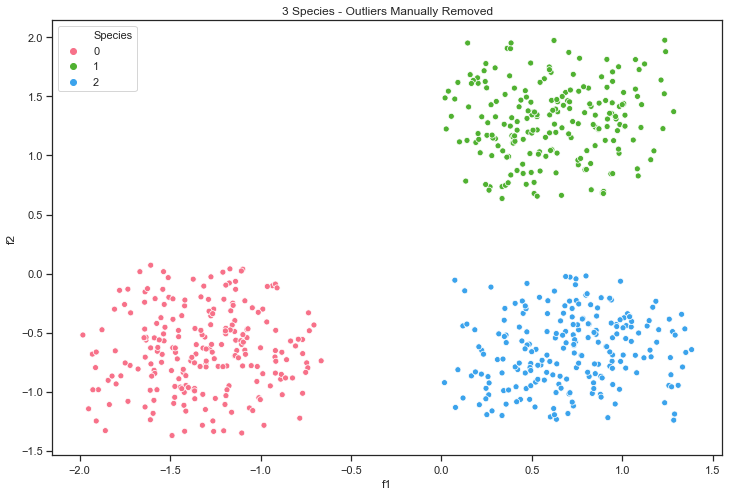

In [17]:
#plotting resulting plot
plt.figure(figsize=(12, 8))
sns.scatterplot(df_manual['f1'], df_manual['f2'], hue=df_manual['Species'], 
                palette=sns.color_palette('husl', 3))
plt.title('3 Species - Outliers Manually Removed')
plt.show()

The clusters appear much more defined after manually removing the outliers 

***

## Problem 4

*Use K-means clustering to find anomalies (Hint: find cluster data points that are far to the centroids).*

In [18]:
# removing outliers/anomalies using Kmeans
df_kmeans = df_org.copy()

# specifying number of clusters and fitting 
kmeans = KMeans(n_clusters=3, init='k-means++',
                n_init=1, verbose=0, max_iter=300, random_state=42)
kmeans.fit(df_kmeans)

# getting the cluster centroids
print('Cluster Centroids:')
print(kmeans.cluster_centers_)
print("")

# getting the cluster labels
print('Cluster Labels:')
print(kmeans.labels_)


Cluster Centroids:
[[-1.30659124 -0.65363509]
 [ 0.62260555  1.3172598 ]
 [ 0.69142719 -0.64788058]]

Cluster Labels:
[1 0 1 2 1 0 0 2 1 1 0 0 0 2 0 1 0 0 0 2 2 2 2 2 0 0 2 1 1 2 1 0 0 1 0 1 2
 1 1 2 2 0 0 0 0 0 1 2 1 0 2 2 0 0 2 2 0 1 2 0 2 2 2 2 2 1 2 2 1 1 1 2 1 1
 2 0 1 0 1 2 0 0 1 1 1 1 0 2 0 2 2 1 0 1 0 1 0 0 1 1 2 0 2 1 2 2 2 2 1 1 1
 0 0 0 0 1 1 0 1 0 2 0 1 1 0 2 0 1 1 2 1 2 2 2 1 0 2 2 1 0 1 2 1 1 2 2 0 2
 0 1 2 0 0 2 2 2 1 0 1 0 1 0 1 2 2 0 0 2 2 0 1 0 2 2 2 0 0 2 2 1 0 2 1 1 2
 1 1 0 1 0 1 0 0 2 2 1 1 0 0 2 0 2 2 2 2 1 2 1 2 2 1 2 2 2 1 1 0 0 0 2 2 2
 2 0 2 2 1 1 2 1 1 1 0 1 0 0 0 2 0 0 1 0 2 2 0 2 2 0 1 1 0 0 0 1 0 1 2 1 2
 2 2 2 2 0 0 1 1 0 0 1 1 2 0 2 2 0 0 2 0 2 1 2 2 1 0 2 2 1 2 2 1 1 2 1 2 1
 2 0 1 1 1 0 2 0 2 2 1 2 2 1 1 2 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 2 1 0 2 2
 1 1 2 1 2 0 1 2 1 2 1 2 2 1 0 1 0 1 2 2 0 0 0 2 1 2 1 2 0 2 2 1 0 1 0 1 1
 1 1 2 1 2 1 0 1 0 2 0 0 0 1 0 0 1 2 0 1 2 2 0 0 2 2 2 0 2 0 2 1 2 0 2 0 1
 0 1 0 0 1 0 2 2 0 1 1 2 0 2 2 2 2 0 1 1 1 1 0 1 2 0 1 0 

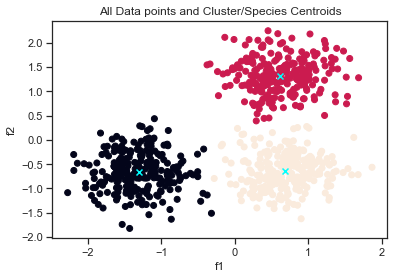

In [19]:
#Plotting centroids with the actual data points

species=kmeans.fit_predict(df_kmeans)

plt.plot()
plt.scatter(df_kmeans['f1'], df_kmeans['f2'], c=species) 
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='cyan', marker='x')
plt.title('All Data points and Cluster/Species Centroids')
plt.xlabel("f1")
plt.ylabel("f2")
plt.show()

We can see above that the centroids actually seem centered around each cluster.  We need to calculate the distance between each datapoint to each centroid and remove the points that are far away from the centroid from the closest cluster.

In [20]:
#making sure I have correct dataset
df_kmeans.shape

(750, 2)

In [21]:
#centroids
centroids = kmeans.cluster_centers_

#print
centroids
#labels
#preds = kmeans.predict(df_kmeans)


array([[-1.30659124, -0.65363509],
       [ 0.62260555,  1.3172598 ],
       [ 0.69142719, -0.64788058]])

In [22]:
def distance(centroid, X, Y):
    distances = []
        
    # unpack the x and y coordinates of centroid
    c_x, c_y = centroid
        
    # iterating datapoints and calculating distance
    for x, y in list(zip(X, Y)):
        root_diff_x = (x - c_x) ** 2
        root_diff_y = (y - c_y) ** 2
        distance = np.sqrt(root_diff_x + root_diff_y)
        distances.append(distance)
        
    return distances


In [23]:
#assiging centroids to different variables
c1 = centroids[0]
c2 = centroids[1]
c3 = centroids[2]

In [24]:
# calculating distance of each point with formula from above and adding to dataframe 
df_kmeans['c1_Distance'] = distance(c1, df_kmeans.f1, df_kmeans.f2)
df_kmeans['c2_Distance'] = distance(c2, df_kmeans.f1, df_kmeans.f2)
df_kmeans['c3_Distance'] = distance(c3, df_kmeans.f1, df_kmeans.f2)
df_kmeans['Species'] = kmeans.labels_

# Preview the data
df_kmeans.head(20)

,f1,f2,c1_Distance,c2_Distance,c3_Distance,Species
0,0.494261,1.451067,2.769989,0.185410,2.108188,1
1,-1.428081,-0.837064,0.220013,2.974294,2.127934,0
2,0.338559,1.038759,2.360237,0.397800,1.723156,1
3,0.119001,-1.053976,1.480738,2.424123,0.701844,2
4,1.122425,1.774937,3.434833,0.677707,2.460854,1
5,-1.261570,0.271881,0.926611,2.154747,2.158740,0
6,-1.301548,-0.762062,0.108544,2.833010,1.996243,0
7,0.585699,-0.339105,1.918252,1.656776,0.326376,2
8,1.082472,0.886855,2.842663,0.629861,1.583771,1
9,1.014167,1.341140,3.060236,0.392289,2.015035,1


We can see above that that the species label and the distance of each point from each centroid has been added. We can then group the dataframe by each species and then remove the datapoints furthest away.

In [25]:
df_kmeans.describe()

,f1,f2,c1_Distance,c2_Distance,c3_Distance,Species
count,7.500000e+02,7.500000e+02,750.000000,750.000000,750.000000,750.000000
mean,5.218196e-15,-7.853703e-14,1.759413,1.759832,1.500624,0.997333
std,1.000667e+00,1.000667e+00,1.019937,1.013495,0.804245,0.818670
min,-2.274474e+00,-1.823801e+00,0.015776,0.036016,0.023305,0.000000
25%,-1.091894e+00,-7.775487e-01,0.627755,0.656193,0.616807,0.000000
50%,3.886712e-01,-4.095144e-01,2.036432,1.999123,1.790238,1.000000
75%,7.787849e-01,1.052538e+00,2.577817,2.574619,2.128652,2.000000
max,1.870438e+00,2.245794e+00,3.732367,3.765108,2.998309,2.000000


In [26]:
#is_0 = df['Species']==0
#is_1 = df['Species']==1
#is_2 = df['Species']==2

#splitting each species into a separate dataframe
df_kmeans0 = df_kmeans[is_0]
df_kmeans1 = df_kmeans[is_1]
df_kmeans2 = df_kmeans[is_2]

print(f'Original Number of Species 0 = {len(df_kmeans0)}')
print(f'Original Number of Species 1 = {len(df_kmeans1)}')
print(f'Original Number of Species 2 = {len(df_kmeans2)}')

Original Number of Species 0 = 252
Original Number of Species 1 = 248
Original Number of Species 2 = 250


In [27]:
#remove datapoints from each speciies if distance from centroid is above: mean + 0.85*standard deviation of the distance

#defining index by species
km_index_0 = df_kmeans0[(df_kmeans0['c1_Distance']) > (df_kmeans0['c1_Distance'].mean() + 
                                                       0.85 * df_kmeans0['c1_Distance'].std())].index

km_index_1 = df_kmeans1[(df_kmeans1['c2_Distance']) > (df_kmeans1['c2_Distance'].mean() + 
                                                       0.85 * df_kmeans1['c2_Distance'].std())].index

km_index_2 = df_kmeans2[(df_kmeans2['c3_Distance']) > (df_kmeans2['c3_Distance'].mean() + 
                                                       0.85 * df_kmeans2['c3_Distance'].std())].index

#dropping outliers
df_kmeans0.drop(km_index_0, inplace=True)
df_kmeans1.drop(km_index_1, inplace=True)
df_kmeans2.drop(km_index_2, inplace=True)

In [28]:
combine2 = [df_kmeans0, df_kmeans1, df_kmeans2]

#combining specicies datasets
df_kmeans_final = pd.concat(combine2)

#printing resulted combined datset without outliers (manually removed)
print(f'Resulting datset shape after manually removing outliers using Kmeans: {df_kmeans_final.shape}\n')

#printing new number of each species
print(f'Resulting number of Species 0 = {len(df_kmeans0)}')
print(f'Resulting number Species 1 = {len(df_kmeans1)}')
print(f'Resulting number of Species 2 = {len(df_kmeans2)}')



Resulting datset shape after manually removing outliers using Kmeans: (610, 6)

Resulting number of Species 0 = 205
Resulting number Species 1 = 203
Resulting number of Species 2 = 202


Based on the chosen threshold of the mean distance + 0.85 * standard deviation of the datapoint's distance from the closest centroid, we removed 140 datapoints as outliers. 

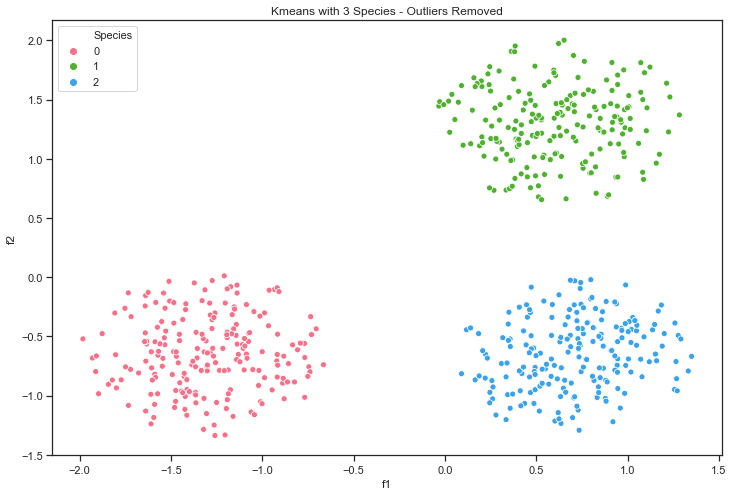

In [29]:
#plotting resulting plot
plt.figure(figsize=(12, 8))
sns.scatterplot(df_kmeans_final['f1'], df_kmeans_final['f2'], hue=df_kmeans_final['Species'], 
                palette=sns.color_palette('husl', 3))
plt.title('Kmeans with 3 Species - Outliers Removed')
plt.show()

Since 140 datapoints were removed as outliers, compared to 106 from the manual method, the clusters appear even more defined.  However, we have to be careful not to remove too many outliers and cause bias.

***

## Problem 5

*Use DBSCAN clustering to find anomalies in the full dataset as an alternative to (Q4.).*

In [30]:
df_dbscan = df_org.copy()
#db = DBSCAN(eps=0.28, min_samples = 20, metric = 'euclidean').fit(df_dbscan)
db = DBSCAN(eps=0.23, min_samples = 20, metric = 'euclidean').fit(df_dbscan)
labels = db.labels_
pd.Series(labels).value_counts()

 2    216
 1    205
 0    197
-1    132
dtype: int64

In [31]:
df_dbscan['Label'] = labels

In [32]:
df_dbscan.describe()

,f1,f2,Label
count,7.500000e+02,7.500000e+02,750.000000
mean,5.218196e-15,-7.853703e-14,0.673333
std,1.000667e+00,1.000667e+00,1.072142
min,-2.274474e+00,-1.823801e+00,-1.000000
25%,-1.091894e+00,-7.775487e-01,0.000000
50%,3.886712e-01,-4.095144e-01,1.000000
75%,7.787849e-01,1.052538e+00,2.000000
max,1.870438e+00,2.245794e+00,2.000000


In [33]:
df_dbscan = df_dbscan[df_dbscan.Label != -1]

df_dbscan.shape

(618, 3)

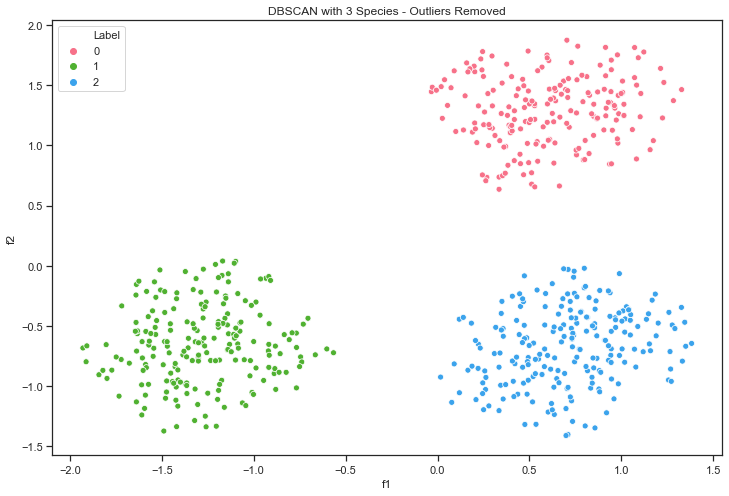

In [34]:
#plotting resulting plot
plt.figure(figsize=(12, 8))
sns.scatterplot(df_dbscan['f1'], df_dbscan['f2'], hue=df_dbscan['Label'], 
                palette=sns.color_palette('husl', 3))
plt.title('DBSCAN with 3 Species - Outliers Removed')
plt.show()

The DBSCAN method of removing outliers seems to be the most simple. However, the number of outliers is dependent on the hyperparameters such as eps and min_simples which is tricky to determine what values work best.  The DBSCAN method removed 132 outliers.

***

## Problem 6

*Now using the cleaned dataset by a method of your choice, develop a decision tree classifier to model the species and show the model decision tree.*

In [35]:
#using code from Module 6 lecture notebook 
#function for determining 10 fold cross validation accuracy

def eval_classifier(_clf, _X, _y):
    acc = []
    kf = KFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        acc += [accuracy_score(_y[test_index], y_pred)]
    return np.array(acc)

In [36]:
#choosing the cleaned dataset using DBSCAN

# Split full df dataset(with labels) into X and Y
X2 = df_dbscan.loc[:, df_dbscan.columns != 'Label'].values
y2 = df_dbscan.loc[:, df_dbscan.columns == 'Label'].values.ravel()

#testing and training sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=None)

In [37]:
X2_train.shape, y2_train.shape

((494, 2), (494,))

In [38]:
X2_test.shape, y2_test.shape

((124, 2), (124,))

In [39]:
#show performance without cleaning cleaning?

dt = DecisionTreeClassifier()
acc_dt = eval_classifier(dt,X2, y2)

print(f'Decision Tree CV accuracy={np.mean(acc_dt):.2f} {chr(177)}{np.std(acc_dt):.3f}')

print(f'Summary of Accuracy Scores: {acc_dt}')

Decision Tree CV accuracy=1.00 ±0.000
Summary of Accuracy Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


[Text(334.8, 679.5, 'f1 <= -0.3\ngini = 0.666\nsamples = 557\nvalue = [178, 186, 193]'),
 Text(167.4, 407.69999999999993, 'gini = 0.0\nsamples = 186\nvalue = [0, 186, 0]'),
 Text(502.20000000000005, 407.69999999999993, 'f2 <= 0.307\ngini = 0.499\nsamples = 371\nvalue = [178, 0, 193]'),
 Text(334.8, 135.89999999999998, 'gini = 0.0\nsamples = 193\nvalue = [0, 0, 193]'),
 Text(669.6, 135.89999999999998, 'gini = 0.0\nsamples = 178\nvalue = [178, 0, 0]')]

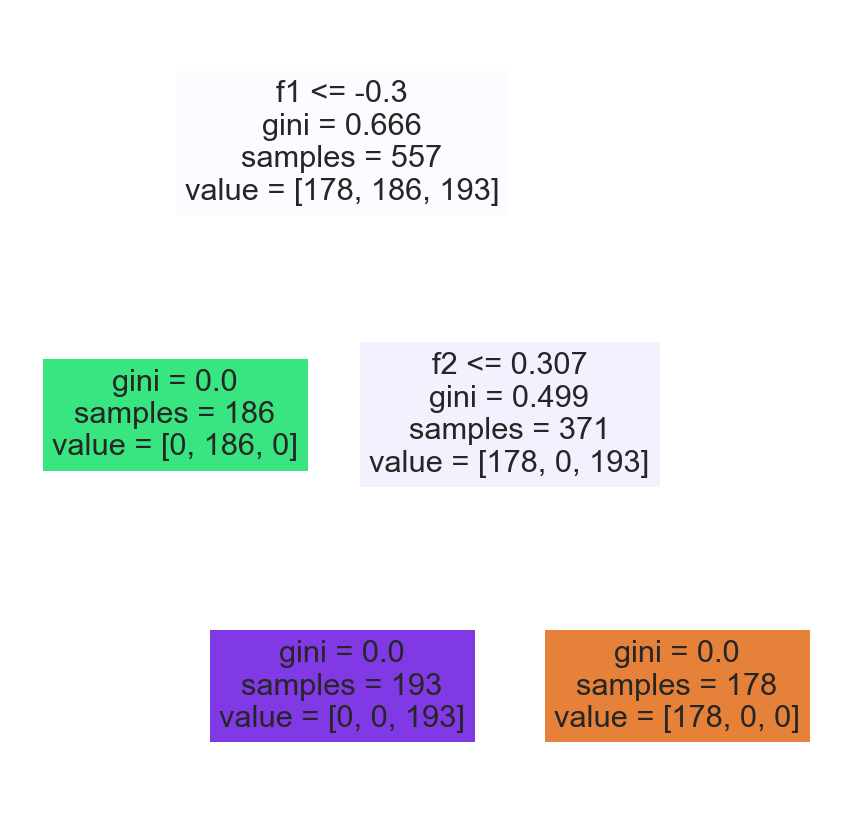

In [40]:
#plot decision tree
fig = plt.figure(figsize=(15,15))
tree.plot_tree(dt, feature_names=['f1','f2'], filled = True) 

The dataset using DBSCAN was chosen since the original dataset, without being cleaned with outliers, appears to be very closely packed together.  DBSCAN was able to very easily identify any datapoints that were in low-density regions. DBSCAN was the easiest method of the three (manual, kmeans, dbscan) in identifying and removing anomalies.

The decision tree model using DBSCAN has an accuray of 1. It's possible that too many outliers were removed. As seen above, the tree structure of the model is very simple which was expected since the dataset had fairly defined clusters even before having removed any outliers.

***

## Problem 7

*Show that, in fact, it helped to clean the outliers as above, before generating the decision tree.*

### Decision Tree model using original (unclean) data

In [41]:
#decision tree model using unclean data

# Split full df dataset(with labels) into X and Y
X3 = df.loc[:, df.columns != 'Species'].values
y3 = df.loc[:, df.columns == 'Species'].values.ravel()

#testing and training sets
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=None)

In [42]:
#check that using correct dataset
X3_train.shape, y3_train.shape

((600, 2), (600,))

In [43]:
#check that using correct dataset
X3_test.shape, y3_test.shape

((150, 2), (150,))

In [44]:
#show performance without cleaning 

dt2 = DecisionTreeClassifier()
acc_dt2 = eval_classifier(dt2,X3, y3)

print(f'Decision Tree CV accuracy={np.mean(acc_dt2):.2f} {chr(177)}{np.std(acc_dt2):.3f}')

print(f'Summary of Accuracy Scores: {acc_dt2}')

Decision Tree CV accuracy=0.99 ±0.009
Summary of Accuracy Scores: [1.         1.         1.         1.         1.         1.
 0.97333333 0.98666667 1.         0.98666667]


[Text(334.8, 713.475, 'f1 <= -0.399\ngini = 0.667\nsamples = 675\nvalue = [229, 225, 221]'),
 Text(167.4, 509.625, 'gini = 0.0\nsamples = 228\nvalue = [228, 0, 0]'),
 Text(502.20000000000005, 509.625, 'f2 <= 0.332\ngini = 0.502\nsamples = 447\nvalue = [1, 225, 221]'),
 Text(334.8, 305.775, 'f1 <= -0.25\ngini = 0.009\nsamples = 222\nvalue = [1, 0, 221]'),
 Text(167.4, 101.92499999999995, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(502.20000000000005, 101.92499999999995, 'gini = 0.0\nsamples = 221\nvalue = [0, 0, 221]'),
 Text(669.6, 305.775, 'gini = 0.0\nsamples = 225\nvalue = [0, 225, 0]')]

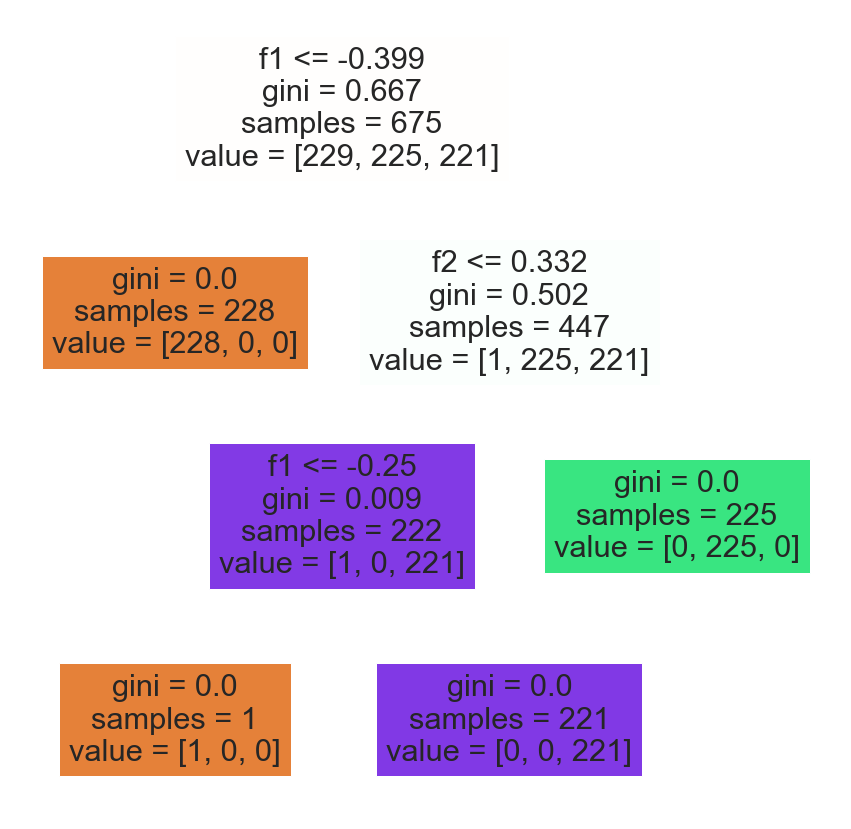

In [45]:
#plot decision tree
fig = plt.figure(figsize=(15,15))
tree.plot_tree(dt2, feature_names=['f1','f2'], filled = True) 

The accuracy, 0.99, of the model using the original unclean dataset is pretty similar to the decision tree using DBSCAN.  The primary difference is that the decision tree with outliers is deeper.  I don't think removing the anomalies made that much of a difference for this dataset which was small and already had fairly defined clusters.  However, from the decision tree above, we can see that larger and more spread out datasets can create complicated decision trees that would negatively impact the performance of the model. Therefore, for such datsets, it is extremely important to identify and remove outliers.

***
## References

https://www.pluralsight.com/guides/cleaning-up-data-from-outliers

https://www.kdnuggets.com/2017/01/3-methods-deal-outliers.html

https://www.kaggle.com/fazilbtopal/popular-unsupervised-clustering-algorithms

https://www.kaggle.com/farhanmd29/unsupervised-learning

https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

https://towardsdatascience.com/outlier-detection-python-cd22e6a12098

https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/
